In [61]:
from glob import glob
from collections import Counter

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.util import view_as_windows
from skimage.transform import resize

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from tqdm.notebook import tqdm

In [87]:
tile_size = 5
image_shape = (605, 700)
small_shape = (605//tile_size, 700//tile_size)
seed = 2020

sp_key = ('m00', 'm10', 'm01', 'm20', 'm11', 'm02', 'm30', 'm21', 'm12', 'm03')
nu_key = ('nu20','nu11','nu02','nu30','nu21','nu12','nu03')

ch_avg = [f'$\mu({x})$' for x in 'BGR']
ch_std = [f'$\sigma({x})$' for x in 'BGR']
hu_mom = [f'$I_{x+1}$' for x in range(7)]
sp_mom = ['$M_{'+x[1:]+'}$' for x in sp_key]
nu_mom = ['$\eta_{'+x[2:]+'}$' for x in nu_key]

features = ch_avg + ch_std + hu_mom + sp_mom + nu_mom
labels = ['label']

In [88]:
def split_image(img, s=tile_size, step=None):
    """
    Split image into SxSxC tiles,where C is the number of channels > 1,
        or SxS tiles if image is grayscale
    """
    gray = len(img.shape) == 2 or img.shape[2] == 1
    if step is None: step = s
    split = lambda shape: view_as_windows(img, shape, step=step)
    if gray:
        return split((s, s)).reshape(-1, s, s)
    else:
        return split((s, s, 3)).reshape(-1, s, s, 3)

def tile_features(img):
    """
    Compute a feature vector of a 5x5x3 tile
    """
    channels = img.reshape(-1, 3)
    mean = np.mean(channels, axis=0)
    std = np.std(channels, axis=0)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #gray = img[:,:,1]
    mom = cv.moments(gray)
    hu = cv.HuMoments(mom)[:,0]
    sp = [mom[k] for k in sp_key]
    nu = [mom[k] for k in nu_key]
    val = img.reshape(-1)
    return np.hstack([mean, std, hu, sp, nu])

def image_features(img, step):
    return np.array([tile_features(x) for x in split_image(img, step=step)])

def image_labels(img, step):
    tiles = split_image(img, step=step)
    return tiles[:,3,3] > 0

def to_rgb(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def equalize(x, limit, grid):
    clahe = cv.createCLAHE(clipLimit=limit, tileGridSize=(grid, grid))
    return clahe.apply(x)

def preprocess_image(x):
    x = cv.cvtColor(x, cv.COLOR_BGR2LAB)
    x = cv.bilateralFilter(x, 5, 15, 15)
    x[:,:,0] = equalize(x[:,:,0], limit=3, grid=8)
    x = cv.cvtColor(x, cv.COLOR_LAB2BGR)
    return x

def sample_data(sample, step=None, skip=False):
    input_img = cv.imread(sample['input_path'])
    label_img = cv.imread(sample['label_path'], cv.IMREAD_GRAYSCALE)
    input_img = preprocess_image(input_img)
    if skip: return input_img, label_img, None, None
    X = image_features(input_img, step=step)
    y = image_labels(label_img, step=step).astype(int)
    return input_img, label_img, X, y

In [89]:
def create_dataset(df):
    total = pd.DataFrame()
    for i, row in tqdm(list(df.iterrows())):
        _, _, X, y = sample_data(row, step=1 if i < 5 else 5)
        chunk = pd.DataFrame(X, columns=features)
        chunk['id'] = row.id
        chunk['label'] = y
        total = pd.concat([total, chunk])

    total['train'] = total.id > 4
    scaler = StandardScaler()
    scaler.fit(total[total.id > 4][features])
    total.loc[:, features] = scaler.transform(total[features])
    return total.reset_index(drop=True)

data = pd.DataFrame(glob('data/*.ah.ppm'), columns=['label_path'])
data['input_path'] = data.label_path.map(lambda x: x.replace('.ah', ''))
data['id'] = data.index
tdata = create_dataset(data)
tdata.head()

,$\mu(B)$,$\mu(G)$,$\mu(R)$,$\sigma(B)$,$\sigma(G)$,$\sigma(R)$,$I_1$,$I_2$,$I_3$,$I_4$,...,$\eta_{20}$,$\eta_{11}$,$\eta_{02}$,$\eta_{30}$,$\eta_{21}$,$\eta_{12}$,$\eta_{03}$,id,label,train
0,-0.702496,-1.769932,-1.725451,-0.693968,-0.668978,-0.416820,4.785077,5.337885,4.484005,1.778719,...,4.720011,-7.117556,4.845001,-5.084698,-0.000086,5.432458,3.984097,0,0,False
1,-0.701030,-1.766563,-1.720398,-0.675308,-0.642613,-0.399869,4.577218,1.906528,0.034713,3.922538,...,4.472161,-3.795016,4.677144,-2.948725,8.767833,-1.363057,5.112730,0,0,False
2,-0.701030,-1.767405,-1.716263,-0.675308,-0.637827,-0.401277,4.506503,1.041539,0.648798,3.707832,...,4.381240,1.997742,4.626606,1.334155,10.756177,-3.718313,5.008599,0,0,False
3,-0.698099,-1.768247,-1.710749,-0.668020,-0.633302,-0.423026,4.612243,6.789412,3.549851,1.799204,...,4.628119,8.188432,4.591802,3.737579,-0.158041,-4.606899,4.592890,0,0,False
4,-0.709822,-1.774985,-1.712128,-0.660552,-0.694083,-0.472165,4.785302,3.091195,2.952143,0.208244,...,4.794678,5.596615,4.771155,2.903110,-4.184211,-4.266371,2.311354,0,0,False


In [90]:
train = tdata[tdata.train]
X, y = train[features], train[labels]

sampler = RandomUnderSampler(sampling_strategy=1, random_state=seed)
X, y = sampler.fit_resample(X, y)

grid = dict(
    max_depth=np.arange(4, 30, 1),
    min_samples_leaf=np.linspace(0.005, 0.1, 100),
    min_samples_split=np.linspace(0.005, 0.1, 100))

clas = RandomForestClassifier(
    n_estimators=500, max_features='sqrt',
    random_state=seed, n_jobs=-1)

clas = RandomizedSearchCV(
    clas, param_distributions=grid, n_iter=50, cv=5, scoring='f1',
    verbose=2, random_state=seed, n_jobs=-1)

clas.fit(X, y)
Y = clas.predict_proba(X)[:, 1]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 15.2min finished
C:\Users\Max\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [105]:
best = np.argmax(clas.cv_results_['rank_test_score'])
keys = 'split0,split1,split2,split3,split4,mean,std'.split(',')
f1 = [clas.cv_results_[f'{k}_test_score'][best] for k in keys]
pd.DataFrame([f1], columns=keys, index=['F1'])

,split0,split1,split2,split3,split4,mean,std
F1,0.869205,0.864207,0.870836,0.806188,0.674197,0.816927,0.075315


In [106]:
clas.best_params_

{'min_samples_split': 0.02994949494949495,
 'min_samples_leaf': 0.005,
 'max_depth': 15}

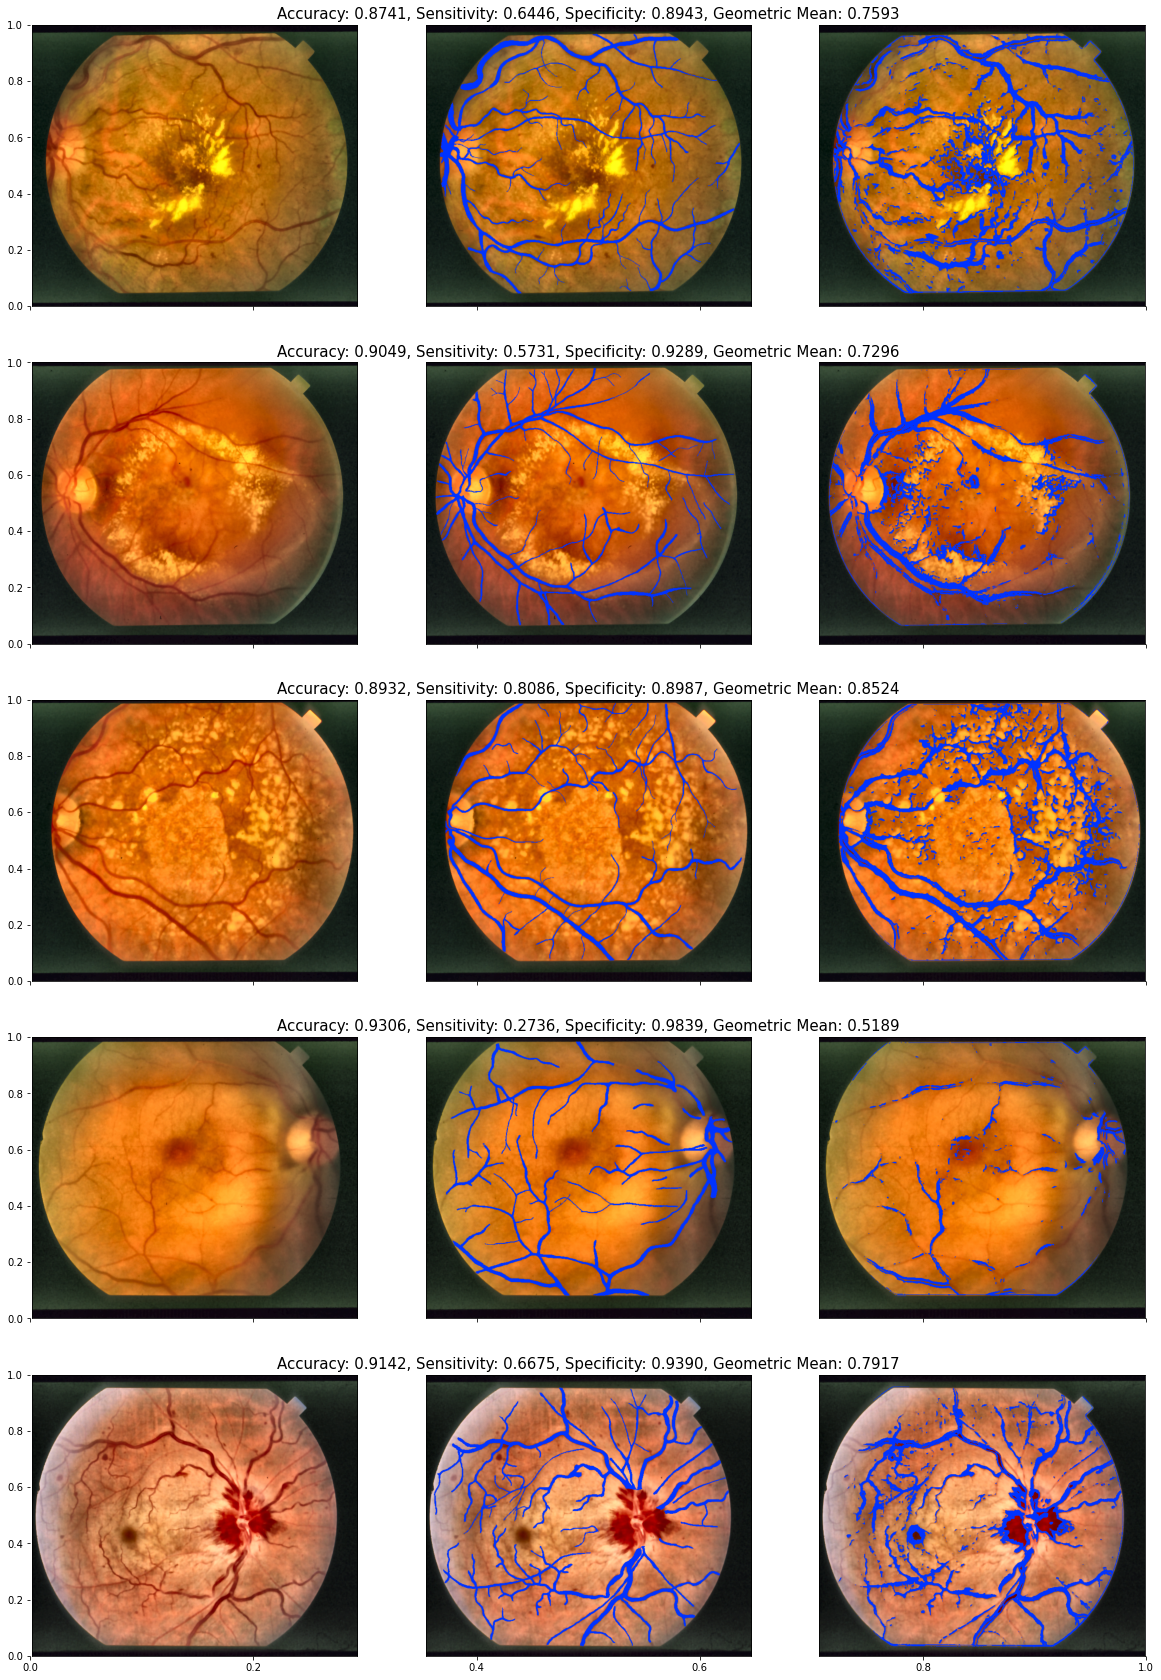

In [108]:
def predict_id(id):
    df = tdata[tdata.id == id]
    X, y = df[features], df.label
    Y = clas.predict_proba(X)[:,1] > 0.7
    return Y

def plot_samples(num):
    fig, axs = plt.subplots(num, 1, sharex=True, sharey=True, figsize=(20, 6*num))
    for i, ax in enumerate(axs):
        X_img, y_img, _, _ = sample_data(data.loc[i, :], step=1, skip=True)
        Y = predict_id(i)
        y = tdata[tdata.id == i].label
        
        contrast = [0,0.2,1]
        X_im = to_rgb(X_img)/255
        y_im = X_im.copy()
        y_im[y_img > 0] = contrast

        mask = np.pad(Y.reshape(601, 696), 2)
        mask = np.dstack([mask]*3)
        Y_im = np.broadcast_to(contrast, X_im.shape)
        Y_im = mask*Y_im + (1-mask)*X_im
    
        tn, fp, fn, tp = confusion_matrix(y, Y).ravel()
        sp = tn / (tn + fp)
        ac, pr, re, f1 = accuracy_score(y, Y), precision_score(y, Y), recall_score(y, Y), f1_score(y, Y)
        mean = np.sqrt(re*sp)
        ax.set_title(f'Accuracy: {ac:.4f}, Sensitivity: {re:.4f}, Specificity: {sp:.4f}, Geometric Mean: {mean:.4f}', fontsize=15)
        ax._frameon = False
        for j, im in enumerate([X_im, y_im, Y_im]):  
            fig.add_subplot(5, 3, i*3 + j+1)
            plt.xticks([]); plt.yticks([])
            plt.imshow(im)

plot_samples(num=5)